### Local RAG agent with LLaMA3

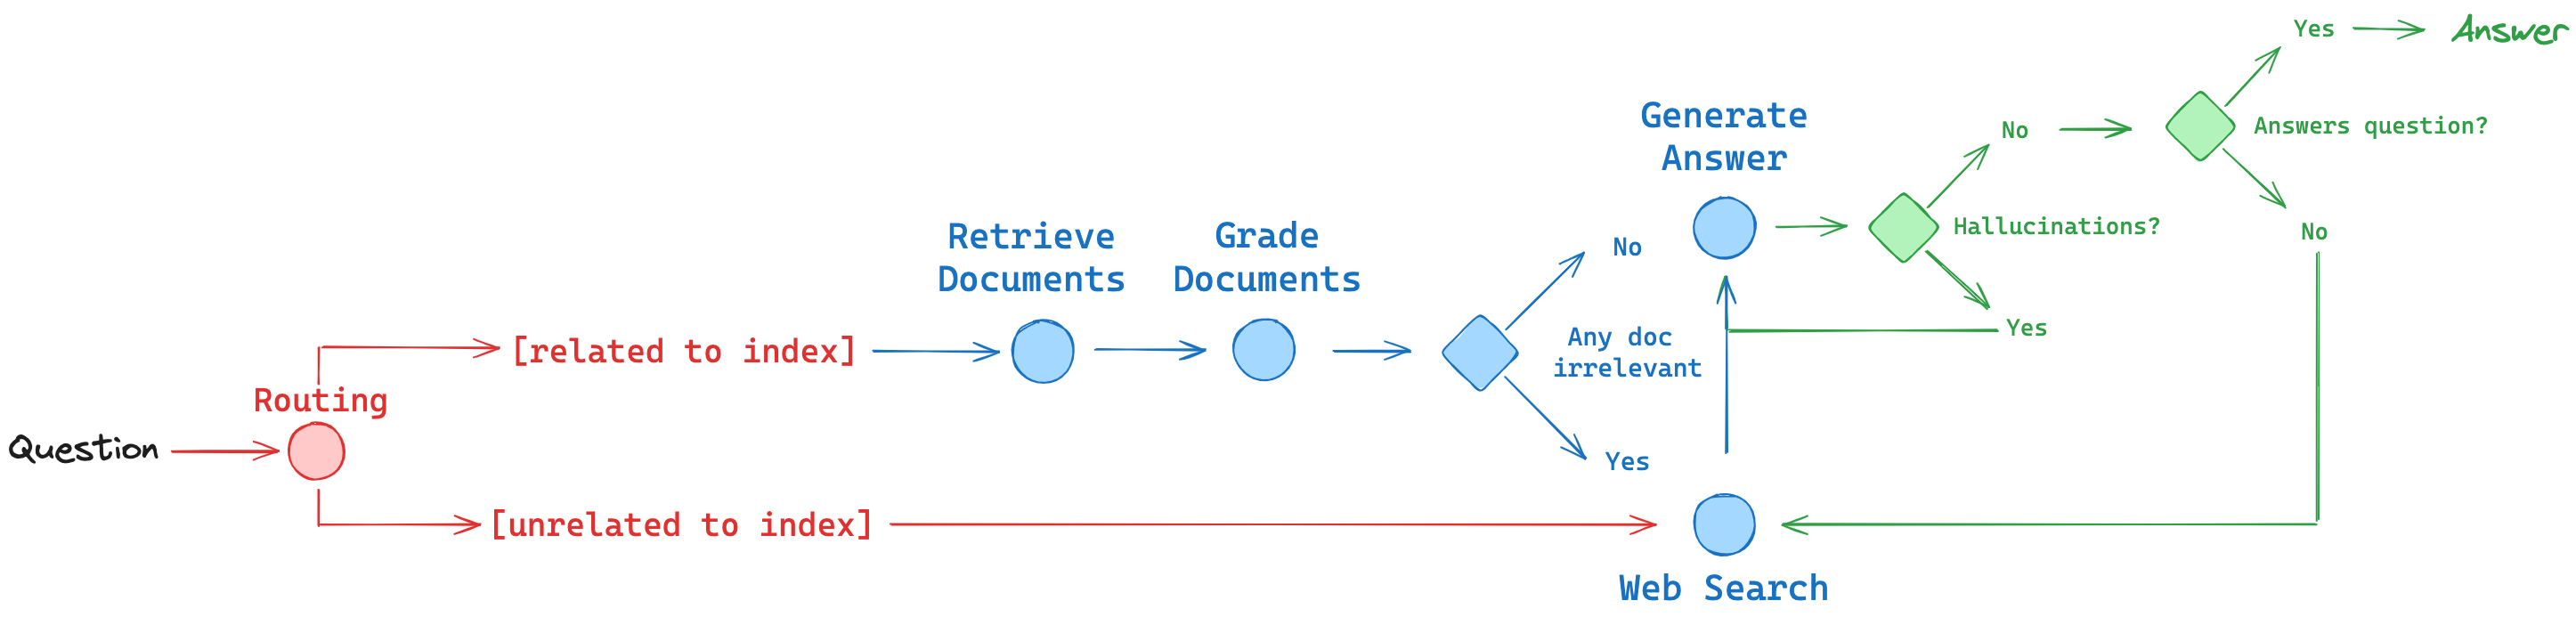

**LLM**

In [164]:
### LLM
from langchain_ollama import ChatOllama
import os
import getpass

In [2]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [3]:
_set_env("OLLAMA_HOST")

In [169]:
!ollama pull "owl/t-lite"

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest 
pulling ff8964056d24...   0% ▕                ▏    0 B/4.7 GB                  pulling manifest 
pulling ff8964056d24...   0% ▕                ▏    0 B/4.7 GB                  pulling manifest 
pulling ff8964056d24...   0% ▕                ▏    0 B/4.7 GB                  pulling manifest 
pulling ff8964056d24...   0% ▕                ▏ 4.4 MB/4.7 GB                  pulling manifest 
pulling ff8964056d24...   0% ▕                ▏  19 MB/4.7 GB                  pulling manifest 
pulling ff8964056d24...   1% ▕                ▏  61 MB/4.7 GB                  pulling manifest 
pulling ff8964056d24...   2% ▕                ▏ 115 MB/4.7 GB                  pulling manifest 

In [171]:
local_llm = "owl/t-lite"
llm = ChatOllama(model=local_llm, temperature=0, num_ctx=4096)
llm_json_mode = ChatOllama(model=local_llm, temperature=0, format="json", num_ctx=4096)

**Search**

In [6]:
_set_env("TAVILY_API_KEY")
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [18]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "local-llama32-rag"

**Vectorstore**

In [9]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [23]:
urls = [
    "https://forpost-sz.ru/a/2024-11-27/kak-sankt-peterburgskij-gornyj-universitet-razvivaetsya-v-sfere-diy-sdelaj-sam",
    "https://forpost-sz.ru/a/2024-11-29/antarkticheskaya-partiya-gornogo-universiteta-derzhit-kurs-v-storonu-shestogo",
    "https://forpost-sz.ru/a/2024-11-28/den-karery-vnov-proveli-v-gornom-universitete",
    "https://forpost-sz.ru/a/2024-11-27/rektor-gornogo-universiteta-predlozhil-sozdat-edinoe-ministerstvo-obrazovaniya"
]

In [24]:
# load docs
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

In [25]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200)

In [26]:
doc_splits = text_splitter.split_documents(docs_list)

In [27]:
_set_env("NOMIC_API_KEY")

In [28]:
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=NomicEmbeddings(model='nomic-embed-text-v1.5'))

In [51]:
retriever = vectorstore.as_retriever(search_kwargs={'k': 3})

In [52]:
retriever.invoke('Алексей Усыпко')

[Document(metadata={'id': '1d7752c0-e367-4211-bd62-c73044cb9f9f', 'source': 'https://forpost-sz.ru/a/2024-11-28/den-karery-vnov-proveli-v-gornom-universitete', 'title': 'В Санкт-Петербургском Горном университете прошел «День карьеры»', 'description': '«День карьеры» - это встреча студентов и потенциальных работодателей на площадке Многофункционального комплекса вуза. В этом году он проводится во второй раз. Представители более чем пятидесяти российских компаний развернули свои стенды с информацией о востребованности выпускников, возможности прохождения практики на предприятиях, социальных гарантиях, карьерных перспективах. Но, конечно, ничто не могло заменить личного общения.', 'language': 'ru'}, page_content='Компания «Уралкалий», как и более трехсот отечественных сырьевых и перерабатывающих холдингов, НИИ и профильных предприятий заключила с Горным договор об «Академическом сотрудничестве». По словам Ольги, ПАО уже принимает студентов на оплачиваемую практику, и помогает в сопровожде

**Components**

In [33]:
### Router
import json
from langchain_core.messages import HumanMessage, SystemMessage

In [172]:
# Prompt
router_instructions = """Ты являешься экспертом в маршрутизации пользовательского вопроса на векторное хранилище или веб-поиск.
Векторное хранилище содержит документы, связанные с Санкт-петербурсгким горным университетом.
Используй векторное хранилище для вопросов по этой теме. Для всех остальных вопросов, особенно связанных с текущими событиями, 
используй веб-поиск.
Верни JSON с единственным ключом datasource, который принимает значение 'websearch' или 'vectorstore' в зависимости от вопроса."""


In [173]:
# Test router
test_web_search = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)] + \
    [HumanMessage(content="Кто выиграл лигу чемпионов в 2024 году?")])

In [174]:
test_web_search_2 = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [HumanMessage(content="Сколько параметров содержит модель Llama3.2?")])

In [175]:
test_vector_store = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [HumanMessage(content="На каком конгрессе выступил ректор Горного университета?")]
)

In [176]:
print(
    json.loads(test_web_search.content),
    json.loads(test_web_search_2.content),
    json.loads(test_vector_store.content),
)

{'datasource': 'websearch'} {'datasource': 'websearch'} {'datasource': 'vectorstore'}


In [177]:
### Retrieval Grader

# Doc grader instructions
doc_grader_instructions = """Ты являешься экспертом, оценивающим релевантность извлечённого документа к вопросу пользователя.
Если документ содержит ключевое слово(а) или семантическое значение, связанное с вопросом, оцени его как релевантный."""

# Grader prompt
doc_grader_prompt = """Вот извлечённый документ: \n\n {document} \n\n Вот вопрос пользователя: \n\n {question}. 
Внимательно и объективно оцени, содержит ли документ хотя бы некоторую информацию, которая имеет отношение к вопросу.
Верни JSON с единственным ключом binary_score, 
который принимает значение 'yes' или 'no', чтобы указать, содержит ли документ хотя бы некоторую релевантную информацию к вопросу."""

# Test
question = "На каком конгрессе выступил ректор Горного университета?"
docs = retriever.invoke(question)
doc_txt = docs[0].page_content
doc_grader_prompt_formatted = doc_grader_prompt.format(
    document=doc_txt, question=question
)
result = llm_json_mode.invoke(
    [SystemMessage(content=doc_grader_instructions)]
    + [HumanMessage(content=doc_grader_prompt_formatted)]
)
json.loads(result.content)

{'binary_score': 'yes'}

In [178]:
### Generate
# Prompt
rag_prompt = """Ты ассистент для выполнения задач по ответам на вопросы.
Вот контекст, который нужно использовать для ответа на вопрос:
{context}
Внимательно изучи указанный выше контекст.
Теперь ознакомься с вопросом пользователя:
{question}
Дай ответ на этот вопрос, используя только указанный контекст.
Используй не более трёх предложений и сделай ответ лаконичным.
Ответ:"""

In [179]:
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [180]:
question = "На каком конгрессе выступил ректор Горного университета?"
docs = retriever.invoke(question)
docs_txt = format_docs(docs)
rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)

In [181]:
generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])

In [182]:
print(generation.content)

Ректор Горного университета выступил на Конгрессе «Профессиональное образование, наука и инновации в XXI веке».


In [183]:
### Hallucination Grader

# Hallucination grader instructions
hallucination_grader_instructions = """
Ты проверяешь тест.  
Тебе будут предоставлены ФАКТЫ и ОТВЕТ. 
Вот критерии оценки:
(1) Убедись, что ОТВЕТ хотя бы частично основан на ФАКТАХ. 
(2) Убедись, что ОТВЕТ не содержит "галлюцинированной" информации, выходящей за рамки предоставленных ФАКТОВ. 
Оценка:
Оценка 'yes' означает, что ответ соответствует обоим критериям.
Оценка 'no' означает, что ответ студента не соответствует всем критериям.
Объясни свою оценку.
Избегай просто указания правильного ответа без объяснения."""

In [184]:
hallucination_grader_prompt = """ФАКТЫ: \n\n {documents} \n\n ОТВЕТ СТУДЕНТА: {generation}. 
Верни JSON с двумя ключами: binary_score — это 'yes' или 'no', 
чтобы указать, основан ли ОТВЕТ на ФАКТАХ. И ключ explanation, который содержит объяснение оценки."""

In [185]:
# Test using documents and generation from above
hallucination_grader_prompt_formatted  = hallucination_grader_prompt.format(documents=docs_txt, generation=generation)

In [187]:
result = llm_json_mode.invoke(
    [SystemMessage(content=hallucination_grader_instructions)] + \
    [HumanMessage(content=hallucination_grader_prompt_formatted)])

In [188]:
json.loads(result.content)

{'binary_score': 'yes',
 'explanation': "Оценка 'yes' обоснована следующим образом: ответ студента напрямую связывает выступление ректора Горного университета на Конгрессе с его стратегией по улучшению высшего образования и подготовке инженеров. Это соответствует критерию (1), так как ОТВЕТ основан на предоставленных ФАКТАХ, а также не содержит дополнительной информации, выходящей за рамки данных фактов."}

**Check the number of tokens**

В сумме должно быть меньше, чем 4096

In [189]:
llm_json_mode.get_num_tokens_from_messages([SystemMessage(content=hallucination_grader_instructions)] + \
    [HumanMessage(content=hallucination_grader_prompt_formatted)])

2596

In [190]:
llm_json_mode.get_num_tokens(json.loads(result.content)['explanation'])

405

In [201]:
### Answer Grader

# Answer grader instructions
answer_grader_instructions = """Ты сопоставляешь тексты, не проверяя правильность информации. 
Тебе будут даны ВОПРОС и ОТВЕТ.
Не нужно проверять правильность ответа, только его соответствие вопросу.
Просто проверяешь, мог ли быть дан такое ответ на вопрос с языковой точки зрения.
Верни оценку "yes", если ответ соответствует вопросу. 
Верни оценку "no", если ответ не соответствует вопросу.
Объясни свой вывод, чтобы убедиться, что твое рассуждение и выводы правильные.
Избегай простого утверждения правильного ответа."""

In [202]:
# Grader prompt
answer_grader_prompt = """ВОПРОС: \n\n {question} \n\n ОТВЕТ СТУДЕНТА: {generation}. 
Возвращай JSON с двумя ключами: binary_score — оценка 'yes' или 'no', чтобы указать, 
соответствует ли ОТВЕТ СТУДЕНТА критериям. И ключ explanation, который содержит объяснение оценки."""

In [203]:
# Test
question = "На каком конгрессе выступил ректор Горного университета?"
answer = "Ректор Горного университета выступил на Конгрессе «Профессиональное образование, наука и инновации в XXI веке»."

In [204]:
# Test using question and generation from above
answer_grader_promt_formatted = answer_grader_prompt.format(question=question, generation=answer)

In [205]:
result = llm_json_mode.invoke(
    [SystemMessage(content=answer_grader_instructions)] + \
    [HumanMessage(content=answer_grader_promt_formatted)])

In [206]:
json.loads(result.content)

{'binary_score': 'yes',
 'explanation': 'Ответ студента соответствует вопросу по нескольким причинам: во-первых, он указывает на конкретное мероприятие (конгресс), что является важным элементом в контексте выступления. Во-вторых, упоминается тематика конгресса («Профессиональное образование» и т.д.), которая также имеет отношение к деятельности ректора университета. Таким образом, ответ логически связан с вопросом.'}

**Web search Tool**

In [207]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [208]:
web_search_tool = TavilySearchResults(max_results=3)

In [209]:
search = web_search_tool.invoke(question)

In [212]:
search[2]['url']

'https://forpost-sz.ru/a/2024-11-27/rektor-gornogo-universiteta-predlozhil-sozdat-edinoe-ministerstvo-obrazovaniya'

**Graph state**

In [213]:
import operator
from typing import List, Annotated, TypedDict

In [214]:
class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in, each graph node.
    """

    question: str  # User question
    generation: str  # LLM generation
    web_search: str  # Binary decision to run web search
    max_retries: int  # Max number of retries for answer generation
    answers: int  # Number of answers generated
    loop_step: Annotated[int, operator.add]
    documents: List[str]  # List of retrieved documents

In [215]:
from langchain.schema import Document
from langgraph.graph import END

In [216]:
### Nodes
def retrieve(state):
    """
    Retrieve documents from vectorstore
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]
    
    documents = retriever.invoke(question)
    return {"documents": documents}

In [240]:
def generate(state):
    """
    Generate answer using RAG on retrieved documents
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state['question']
    documents = state['documents']
    loop_step = state.get('loop_step', 0)

    # RAG generation
    docs_txt = format_docs(documents)
    rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {'generation': generation, 'loop_step': loop_step + 1}

In [241]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state['question']
    documents = state['documents']

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        doc_grader_prompt_formatted = doc_grader_prompt.format(document=d.page_content, question=question)
        
        result = llm_json_mode.invoke(
            [SystemMessage(content=doc_grader_instructions)] + \
            [HumanMessage(content=doc_grader_prompt_formatted)])
        
        grader = json.loads(result.content)['binary_score']

        if grader.lower() == 'yes':
            print('---GRADE: DOCUMENT RELEVANT---')
            filtered_docs.append(d)
        else:
            print('---GRADE: DOCUMENT NOT RELEVANT---')
            web_search = 'yes'
            continue
    return {'documents': filtered_docs, "web_search": web_search}

In [242]:
def web_search(state):
    """
    Web search based on the question
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Appended web results to documents
    """
    print("---WEB SEARCH---")
    question = state['question']
    documents = state.get("documents", [])

    docs = web_search_tool.invoke({'query': question})
    web_results = "\n".join([d['content'] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {'documents': documents}

In [243]:
### Edges

def route_question(state):
    """
    Route question to web search or RAG
    Args:
        state (dict): The current graph state
    Returns:
        str: Next node to call
    """
    print('---ROUTE QUESTION---')
    route_question = llm_json_mode.invoke(
        [SystemMessage(content=router_instructions)] + \
        [HumanMessage(content=state['question'])])
    
    source = json.loads(route_question.content)['datasource']
    if source == 'websearch':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return 'websearch'
    elif source == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return 'vectorstore'

In [244]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search
    Args:
        state (dict): The current graph state
    Returns:
        str: Binary decision for next node to call
    """ 
    print("---ASSESS GRADED DOCUMENTS---")
    question = state['question']
    web_search = state['web_search']
    filtered_documents = state['documents']

    if web_search == 'yes':
        print("---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return 'websearch'
    else:
        print("---DECISION: GENERATE---")
        return 'generate'

In [245]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question
    Args:
        state (dict): The current graph state
    Returns:
        str: Decision for next node to call
    """
    print("---CHECK HALLUCINATIONS---")
    question = state['question']
    documents = state['documents']
    generation = state['generation']
    max_retries = state.get('max_retries', 3)

    hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
        documents=format_docs(documents), generation=generation.content)
    
    result = llm_json_mode.invoke(
        [SystemMessage(content=hallucination_grader_instructions)] + \
        [HumanMessage(content=hallucination_grader_prompt_formatted)])
    
    grader = json.loads(result.content)['binary_score']

    if grader == 'yes':
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        print("---GRADE GENERATION vs QUESTION---")
        answer_grader_promt_formatted = answer_grader_prompt.format(
            question=question, generation=generation.content)
        
        result = llm_json_mode.invoke(
            [SystemMessage(content=answer_grader_instructions)] + \
            [HumanMessage(content=answer_grader_promt_formatted)])
        
        grader = json.loads(result.content)['binary_score']
        
        if grader == 'yes':
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return 'useful'
        elif state['loop_step'] <= max_retries:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return 'not useful'
        else:
            print("---DECISION: MAX RETRIES REACHED---")
            return "max retries"
        
    elif state['loop_step'] <= max_retries:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return 'not supported'
    else:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"

**Control Flow**

In [246]:
from langgraph.graph import StateGraph
from IPython.display import Image, display

In [247]:
workflow = StateGraph(GraphState)

In [248]:
workflow.add_node('websearch', web_search)
workflow.add_node('retrieve', retrieve)
workflow.add_node('grade_documents', grade_documents)
workflow.add_node('generate', generate)

In [249]:
workflow.set_conditional_entry_point(
    route_question, 
    {"websearch": "websearch", 'vectorstore': 'retrieve'})

In [250]:
workflow.add_edge('websearch', 'generate')
workflow.add_edge('retrieve', 'grade_documents')
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {'websearch': 'websearch', 'generate': 'generate'})
workflow.add_conditional_edges(
    'generate',
    grade_generation_v_documents_and_question,
    {'not supported': 'generate', 'useful': END, 'not useful': 'websearch', 'max retries': END})

In [251]:
graph = workflow.compile()

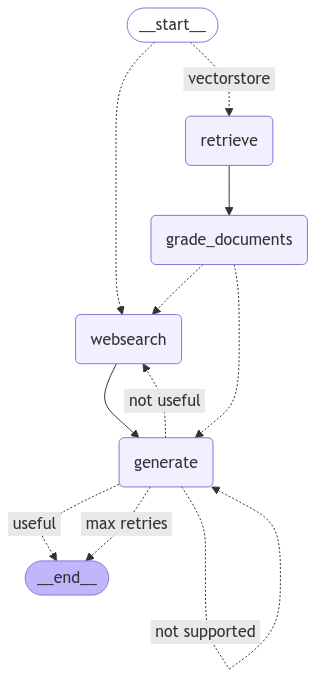

In [252]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [259]:
inputs = {'question': "На каком конгрессе выступил ректор Горного университета?", "max_retries": 3}
for event in graph.stream(inputs, stream_mode='values'):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
{'question': 'На каком конгрессе выступил ректор Горного университета?', 'max_retries': 3, 'loop_step': 0}
---RETRIEVE---
{'question': 'На каком конгрессе выступил ректор Горного университета?', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={'id': '0b4be6d3-8449-4901-9e4e-538ef5cefaea', 'source': 'https://forpost-sz.ru/a/2024-11-27/rektor-gornogo-universiteta-predlozhil-sozdat-edinoe-ministerstvo-obrazovaniya', 'title': 'Ректор Горного университета выступил на Конгрессе «Профессиональное образование, наука и инновации в XXI веке»', 'description': 'В Петербурге стартовала Неделя науки и профессионального образования. Установочным событием первого дня стало пленарное заседание, в котором в качестве спикера принял участие ректор Горного университета Владимир Литвиненко. В рамках своего выступления основной проблемой отечественного образования ректор назвал плохую подготовку будущих студентов еще в школе. Единой государст

In [257]:
inputs = {'question': "Что такое орешник в плане вооружения?", "max_retries": 3}
for event in graph.stream(inputs, stream_mode='values'):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
{'question': 'Что такое орешник в плане вооружения?', 'max_retries': 3, 'loop_step': 0}
---WEB SEARCH---
{'question': 'Что такое орешник в плане вооружения?', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={}, page_content='Что такое Орешник Орешник это российская баллистическая ракета средней дальности (БРСД). Впервые о ней стало известно 21 ноября 2024 года, когда об ударе «Орешником» в безъядерном гиперзвуковом\nНапример, ракету РСД-10 «Пионер», которая стояла на\xa0вооружении с\xa01970-х годов и\xa0вплоть до\xa0вступления в\xa0силу Договора о\xa0ликвидации ракет средней и\xa0меньшей дальности в\xa01988 году. Поэтому многие комментаторы сходятся на\xa0том, что, вероятнее всего, «Орешник», о\xa0котором говорил Путин, это на\xa0самом деле либо комплекс, который может запускать ракеты на\xa0800 километров, либо дальнейшее его развитие по\xa0пути сокращения дальности. Дело в\xa0том, что использовать межконтинента